# BERT Embeddings

### Objective:

1) Use BERT embeddings as a feature extractors. <br>
2) Get embeddings for each keywords using bert as a service. <br>
3) Store the feature matrix.<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from bert_serving.client import BertClient
import joblib
from nltk.tokenize import word_tokenize
%matplotlib notebook

In [2]:
keywords_data = pd.read_csv("./datasets/keywords.csv")

In [3]:
keywords_data.shape

(31379, 4)

In [4]:
keywords_data.head()

,Unnamed: 0,project,keyword,file
0,0,integrated spice modeling/simulation of circui...,circuit element,./reports_doc/1.pdf
1,1,integrated spice modeling/simulation of circui...,circuit simulation,./reports_doc/1.pdf
2,2,integrated spice modeling/simulation of circui...,circuit spice,./reports_doc/1.pdf
3,3,integrated spice modeling/simulation of circui...,component library,./reports_doc/1.pdf
4,4,integrated spice modeling/simulation of circui...,current source,./reports_doc/1.pdf


In [5]:
keywords_data.drop("Unnamed: 0", inplace=True, axis=1)

In [6]:
keywords_data.head()

,project,keyword,file
0,integrated spice modeling/simulation of circui...,circuit element,./reports_doc/1.pdf
1,integrated spice modeling/simulation of circui...,circuit simulation,./reports_doc/1.pdf
2,integrated spice modeling/simulation of circui...,circuit spice,./reports_doc/1.pdf
3,integrated spice modeling/simulation of circui...,component library,./reports_doc/1.pdf
4,integrated spice modeling/simulation of circui...,current source,./reports_doc/1.pdf


In [7]:
def plot_10_most_common_words(count_data, count_vectorizer):
    
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

In [8]:
vec = CountVectorizer(analyzer="word", stop_words="english")

In [9]:
vec_data = vec.fit_transform(keywords_data['keyword'])

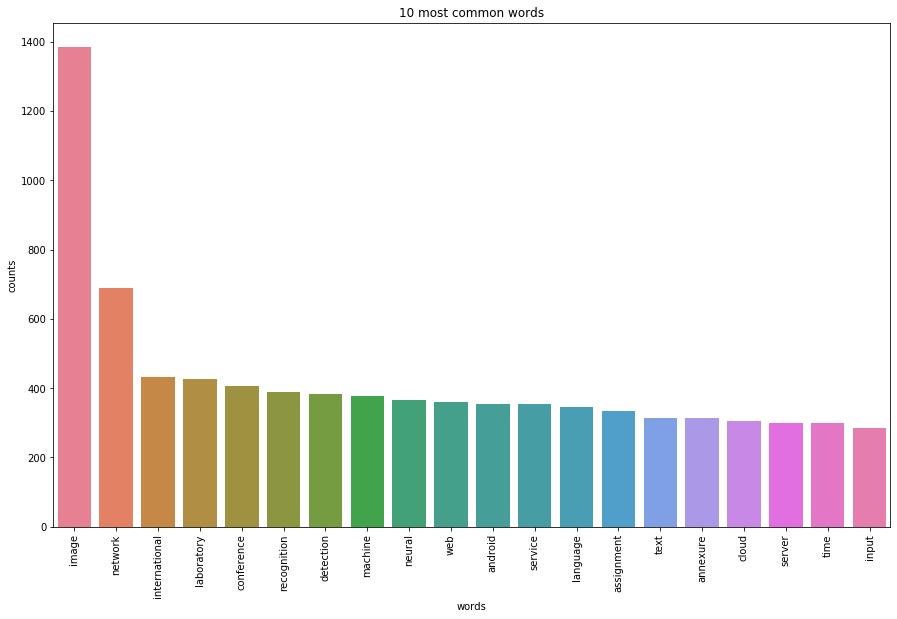

Wall time: 2.14 s


In [10]:
%%time
plot_10_most_common_words(vec_data, vec)

In [11]:
keywords_data.shape

(31379, 3)

In [12]:
%%time
keywords_data['len'] = keywords_data["keyword"].apply(lambda x: len(word_tokenize(x)))

Wall time: 2.25 s


In [13]:
keywords_data.head()

,project,keyword,file,len
0,integrated spice modeling/simulation of circui...,circuit element,./reports_doc/1.pdf,2
1,integrated spice modeling/simulation of circui...,circuit simulation,./reports_doc/1.pdf,2
2,integrated spice modeling/simulation of circui...,circuit spice,./reports_doc/1.pdf,2
3,integrated spice modeling/simulation of circui...,component library,./reports_doc/1.pdf,2
4,integrated spice modeling/simulation of circui...,current source,./reports_doc/1.pdf,2


In [14]:
max(keywords_data['len'])

3

In [15]:
bert_client = BertClient()

In [16]:
%%time
bert_feature_matrix = pd.DataFrame(bert_client.encode(list(keywords_data['keyword'])))

Wall time: 8min 45s


In [17]:
bert_feature_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.139267,-0.238774,-0.237945,0.013400,0.264906,0.342055,-0.322189,-0.027225,-0.173771,-0.181245,...,0.242832,-0.200702,0.122015,-0.100333,0.209277,0.048709,0.029986,-0.261671,-0.528807,0.079673
1,0.119038,-0.278711,-0.619311,-0.133730,0.380638,0.022915,-0.835069,0.050931,-0.540607,-0.364670,...,0.358282,-0.055123,0.209902,-0.100428,0.016472,0.250854,0.084844,-0.344827,-0.430541,0.125937
2,0.061365,-0.437569,-0.372637,-0.166424,0.412393,0.078075,-0.037316,0.360972,-0.254026,-0.371124,...,0.659710,-0.054744,-0.159384,-0.028298,0.199427,-0.068297,0.190459,0.007412,-0.364597,-0.302665
3,0.169346,-0.617061,-0.048252,-0.045413,0.371052,0.203897,-0.169113,0.002753,-0.239400,-0.296700,...,0.300038,-0.180570,-0.102940,-0.041319,-0.195440,0.148902,-0.028296,-0.284535,-0.280654,0.016216
4,-0.127349,-0.048348,0.150936,-0.412035,0.169691,0.317753,0.127675,0.111950,0.033940,-0.660292,...,0.157766,-0.134757,-0.764668,-0.300187,-0.224190,-0.302015,0.056666,-0.508374,-0.816871,0.275807


In [18]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

In [19]:
%%time
bert_tsne = tsne_model.fit_transform(bert_feature_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 31379 samples in 2.450s...
[t-SNE] Computed neighbors for 31379 samples in 1611.333s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31379
[t-SNE] Computed conditional probabilities for sample 2000 / 31379
[t-SNE] Computed conditional probabilities for sample 3000 / 31379
[t-SNE] Computed conditional probabilities for sample 4000 / 31379
[t-SNE] Computed conditional probabilities for sample 5000 / 31379
[t-SNE] Computed conditional probabilities for sample 6000 / 31379
[t-SNE] Computed conditional probabilities for sample 7000 / 31379
[t-SNE] Computed conditional probabilities for sample 8000 / 31379
[t-SNE] Computed conditional probabilities for sample 9000 / 31379
[t-SNE] Computed conditional probabilities for sample 10000 / 31379
[t-SNE] Computed conditional probabilities for sample 11000 / 31379
[t-SNE] Computed conditional probabilities for sample 12000 / 31379
[t-SNE] Computed conditional probabilities for 

In [20]:
%%time
joblib.dump(bert_feature_matrix, "./models/bert_embeddings.pkl")

Wall time: 251 ms


['./models/bert_embeddings.pkl']

In [22]:
bert_tsne = pd.DataFrame(bert_tsne, columns=["col1", "col2"])

In [24]:
keywords = list(keywords_data["keyword"])

In [31]:
%matplotlib notebook

<IPython.core.display.Javascript object>


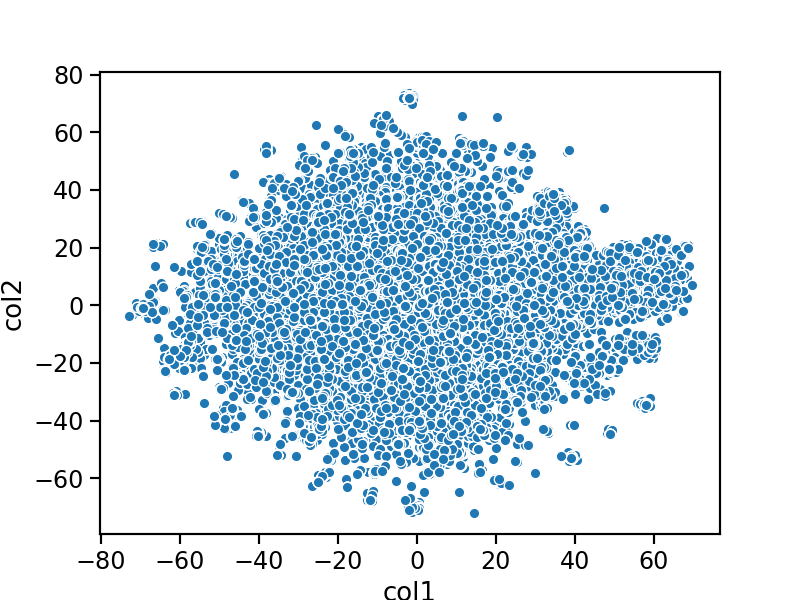

In [32]:
sns.scatterplot(x="col1", y="col2", data=bert_tsne)

In [45]:
bert_tsne["project"] = keywords_data["project"]

<IPython.core.display.Javascript object>


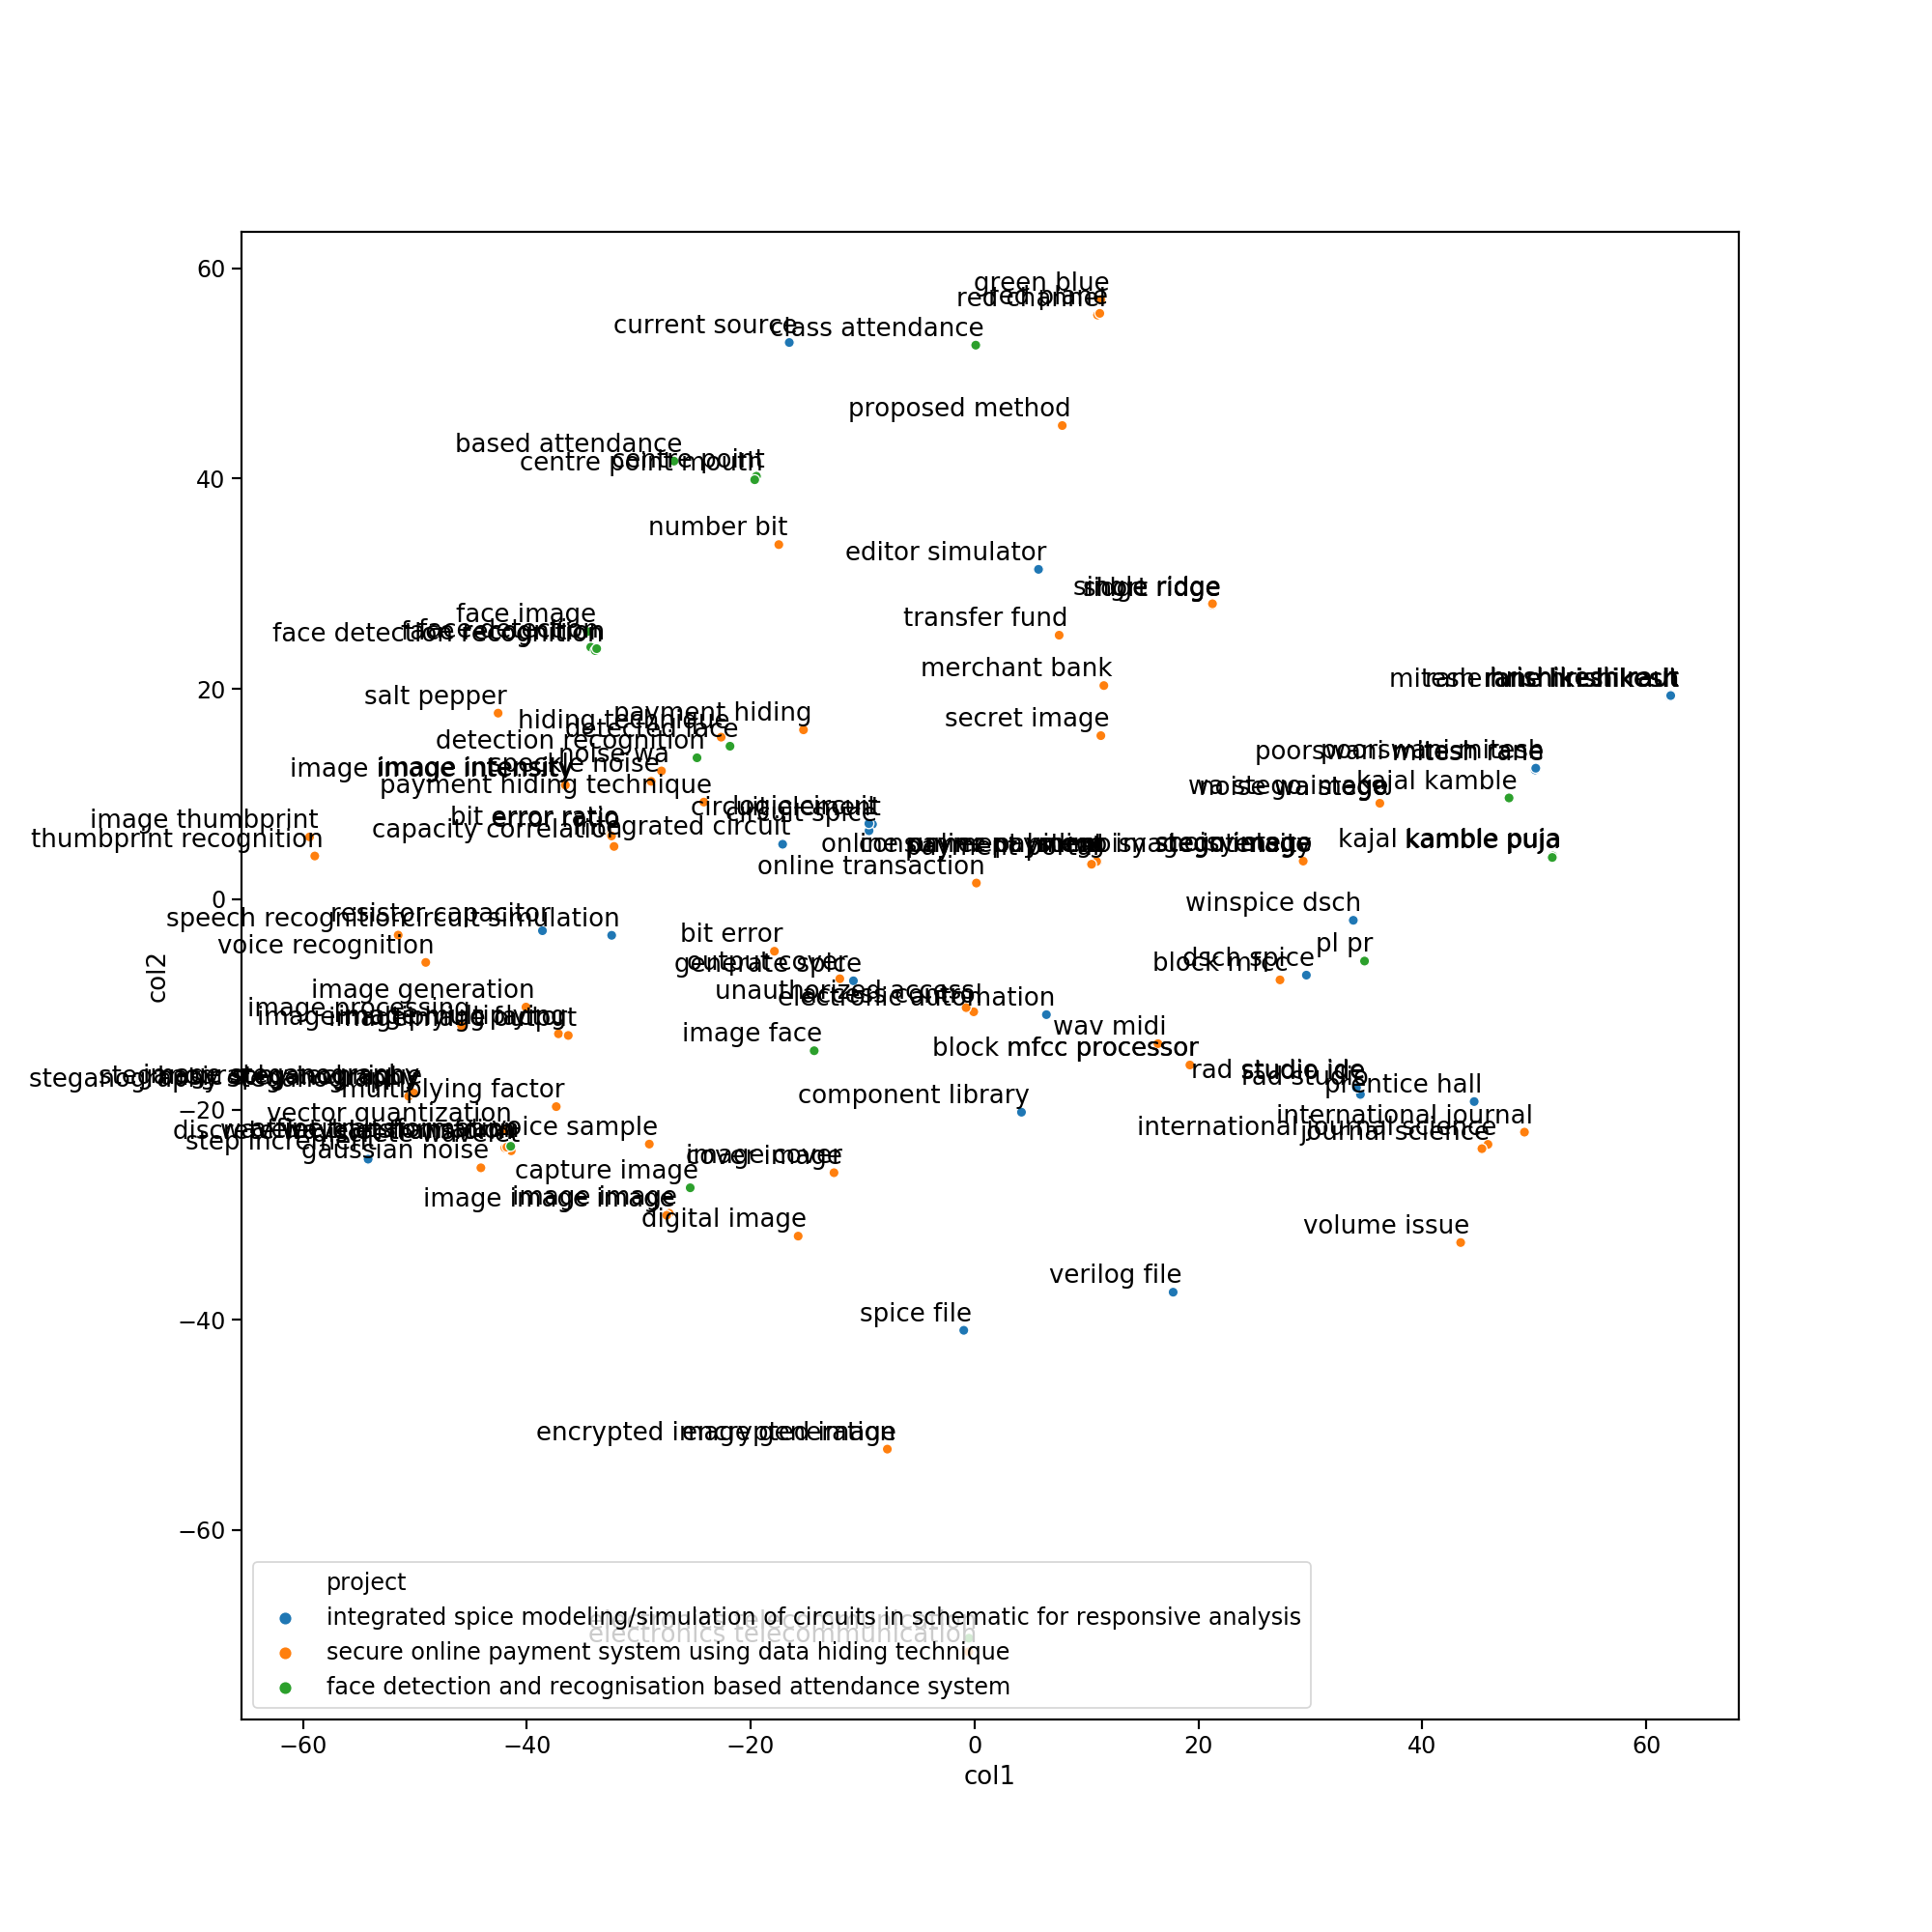

In [72]:
plt.figure(figsize=(16, 16))
sns.scatterplot(x="col1", y="col2", data=bert_tsne[:120], hue="project")
for i in range(len(bert_tsne[:120])):
    plt.annotate(keywords[i], xy=(bert_tsne["col1"][i], bert_tsne["col2"][i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=15)
plt.show()